In [1]:
import numpy as np
import pandas as pd
import yaml
import os
os.chdir('/workspace') # change to the root directory of the project

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, roc_curve, roc_auc_score, jaccard_score

from utils import maldi_normalize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load the data

In [2]:
# Load the MSI data
peaks = pd.read_feather("data/mse_conc_peaks_complete.feather")
pixels = pd.read_feather("data/mse_conc_pixels_complete.feather")

# Define the densities and a threshold for each pixel density

In [3]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

# Remove the Trypsin peaks

In [4]:
# Load the trypsin peaks from a file
with open("trypsin_peaks.yml", "r") as f:
    trypsin_masses = yaml.safe_load(f)

# Extract the trypsin peaks
trypsin_peaks = [peak for peak in peaks.columns if np.min(np.abs(float(peak) - np.array(trypsin_masses))) < 0.2]

print(f"Found {len(trypsin_peaks)} trypsin peaks")
for peak in trypsin_peaks:
    print(f"peak: {float(peak)}, mass: {trypsin_masses[np.argmin(np.abs(float(peak) - np.array(trypsin_masses)))]:.2f} ,diff: {np.min(np.abs(float(peak) - np.array(trypsin_masses))):.2f}")

Found 12 trypsin peaks
peak: 515.3292, mass: 515.33 ,diff: 0.00
peak: 842.476, mass: 842.51 ,diff: 0.03
peak: 906.3916, mass: 906.50 ,diff: 0.11
peak: 1006.4606, mass: 1006.49 ,diff: 0.03
peak: 1045.5339, mass: 1045.56 ,diff: 0.03
peak: 1469.6891, mass: 1469.73 ,diff: 0.04
peak: 1736.8208, mass: 1736.84 ,diff: 0.02
peak: 1768.823, mass: 1768.80 ,diff: 0.02
peak: 2158.0994, mass: 2158.03 ,diff: 0.07
peak: 2211.0896, mass: 2211.10 ,diff: 0.01
peak: 2283.1072, mass: 2283.18 ,diff: 0.07
peak: 3013.4917, mass: 3013.32 ,diff: 0.17


# Benchmark the different normalization methods

In [ ]:
# Benchmark the different normalization methods for the CD8 density prediction
results = []

for normalization_method in ['PQN', 'TIC', 'Mean', 'Median', 'RMS', 'MAX', 'Quantile']:
    
    print(f"{normalization_method} normalization")
    
    # Normalize the peaks
    peaks_norm = peaks.copy()
    for lame in lames:
        peaks_norm.loc[pixels['run'] == lame] = maldi_normalize(peaks=peaks[pixels['run'] == lame],
                                                                method=normalization_method)
    
    # Exclude the non lesion pixels
    peaks_norm_lesion = peaks_norm[pixels['Density_Lesion'] > 0.5]
    pixels_lesion = pixels[pixels['Density_Lesion'] > 0.5]

    # Create a linear regression model
    model_reg = LinearRegression()
    
    # Train the model
    model_reg.fit(peaks_norm_lesion.values, pixels_lesion['Density_CD8'].values)

    # Calculate the R2 score
    r2 = model_reg.score(peaks_norm_lesion.values, pixels_lesion['Density_CD8'].values)

    # Predict the CD8 density
    y_pred = model_reg.predict(peaks_norm_lesion.values)

    # Compute the mean squared error
    mse = mean_squared_error(pixels_lesion['Density_CD8'].values, y_pred)

    # Calculate the pearson correlation
    pearson_correlation = np.corrcoef(pixels_lesion['Density_CD8'].values, y_pred)[0, 1]

    print(f"R2: {r2:.4f}, MSE: {mse:.4f}, Pearson Correlation: {pearson_correlation:.4f}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(peaks_norm_lesion.values, pixels_lesion['Density_CD8'].values,
                                                        test_size=0.1,
                                                        random_state=42)
    
    # Adjust the y values to be binary
    y_train = y_train > threshold['Density_CD8']
    y_test = y_test > threshold['Density_CD8']

    # Create a logistic regression model
    model_log = LogisticRegression(max_iter=10**6, class_weight='balanced')

    # Train the model
    model_log.fit(X_train, y_train)

    # Make predictions
    y_pred = model_log.predict(X_test)

    # Compute the accuracy using accuracy_score
    accuracy_train = model_log.score(X_train, y_train)
    accuracy_test = accuracy_score(y_test, y_pred)

    # Compute the IOU
    iou_train = jaccard_score(y_train, model_log.predict(X_train))
    iou_test = jaccard_score(y_test, y_pred)

    # Compute the AUC
    auc_train = roc_auc_score(y_train, model_log.predict_proba(X_train)[:, 1])
    auc_test = roc_auc_score(y_test, model_log.predict_proba(X_test)[:, 1])

    print(f"Accuracy (train): {accuracy_train:.4f}, Accuracy (test): {accuracy_test:.4f}")
    print(f"IOU (train): {iou_train:.4f}, IOU (test): {iou_test:.4f}")
    print(f"AUC (train): {auc_train:.4f}, AUC (test): {auc_test:.4f}")

    # Append the results to the list
    results.append({
        'Normalization': normalization_method,
        'R2': r2,
        'MSE': mse,
        'Pearson Correlation': pearson_correlation,
        'Accuracy (train)': accuracy_train,
        'Accuracy (test)': accuracy_test,
        'IOU (train)': iou_train,
        'IOU (test)': iou_test,
        'AUC (train)': auc_train,
        'AUC (test)': auc_test
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

PQN normalization
R2: 0.2081, MSE: 0.0008, Pearson Correlation: 0.4562
Accuracy (train): 0.7875, Accuracy (test): 0.7834
IOU (train): 0.2572, IOU (test): 0.2516
AUC (train): 0.8844, AUC (test): 0.8704
TIC normalization
R2: 0.1935, MSE: 0.0008, Pearson Correlation: 0.4399
Accuracy (train): 0.6844, Accuracy (test): 0.6871
IOU (train): 0.1702, IOU (test): 0.1745
AUC (train): 0.7761, AUC (test): 0.7787
Mean normalization
R2: 0.1935, MSE: 0.0008, Pearson Correlation: 0.4399
Accuracy (train): 0.7875, Accuracy (test): 0.7829
IOU (train): 0.2597, IOU (test): 0.2529
AUC (train): 0.8884, AUC (test): 0.8744
Median normalization
R2: 0.1954, MSE: 0.0008, Pearson Correlation: 0.4421
Accuracy (train): 0.7867, Accuracy (test): 0.7822
IOU (train): 0.2583, IOU (test): 0.2520
AUC (train): 0.8886, AUC (test): 0.8767
RMS normalization
R2: 0.1778, MSE: 0.0008, Pearson Correlation: 0.4216
Accuracy (train): 0.7832, Accuracy (test): 0.7792
IOU (train): 0.2558, IOU (test): 0.2510
AUC (train): 0.8851, AUC (test)

,Normalization,R2,MSE,Pearson Correlation,Accuracy (train),Accuracy (test),IOU (train),IOU (test),AUC (train),AUC (test)
0,PQN,0.208086,0.000781,0.456165,0.787512,0.783380,0.257161,0.251631,0.884413,0.870429
1,TIC,0.193524,0.000795,0.439914,0.684441,0.687064,0.170191,0.174477,0.776089,0.778726
2,Mean,0.193524,0.000795,0.439914,0.787490,0.782908,0.259661,0.252933,0.888446,0.874354
3,Median,0.195427,0.000793,0.442072,0.786661,0.782174,0.258292,0.251981,0.888573,0.876652
4,RMS,0.177782,0.000811,0.421642,0.783193,0.779202,0.255816,0.250993,0.885086,0.867640
5,MAX,0.167523,0.000821,0.409296,0.778638,0.777034,0.252040,0.251277,0.881892,0.867270
6,Quantile,0.166789,0.000821,0.408398,0.781033,0.777209,0.254289,0.249750,0.883327,0.864779


In [12]:
# Save the results to a file
results_df.to_csv("data/CD8_density_prediction.csv", index=False)

In [10]:
# Noramlize the peaks using PQN
peaks_norm = peaks.copy()
for lame in lames:
    peaks_norm[pixels['run'] == lame] = maldi_normalize(peaks[pixels['run'] == lame])

In [26]:
# Extract the peaks for the lesion pixels
peaks_lesion = peaks[pixels['Density_Lesion'] > 0.5].reset_index(drop=True)

# Extract the normalized peaks for the lesion pixels
peaks_norm_lesion = peaks_norm[pixels['Density_Lesion'] > 0.5].reset_index(drop=True)

In [ ]:
# Save the normalized peaks to feather
peaks_norm.to_feather("data/mse_conc_peaks_normalized_complete.feather")
peaks_norm_lesion.to_feather("data/mse_conc_peaks_normalized.feather")

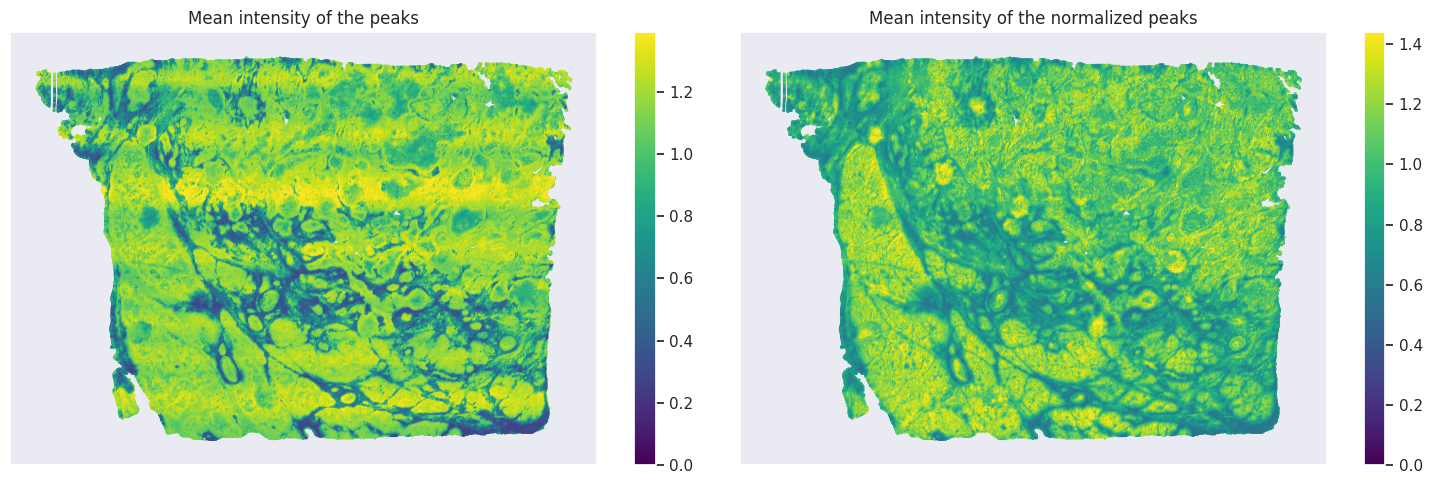

In [9]:
image = peaks[pixels['run'] == lames[0]].mean(axis=1)
image_normalized = peaks_norm[pixels['run'] == lames[0]].mean(axis=1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), tight_layout=True)

# Scatter the mean of the peaks
axs[0].scatter(x=pixels[pixels['run'] == lames[0]]['x_warped'], y=pixels[pixels['run'] == lames[0]]['y_warped'], c=image, cmap='viridis', s=1, vmin=0, vmax=image.quantile(0.99))
axs[0].set_title("Mean intensity of the peaks")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].axis('equal')
axs[0].invert_yaxis()
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x=pixels[pixels['run'] == lames[0]]['x_warped'], y=pixels[pixels['run'] == lames[0]]['y_warped'], c=image_normalized, cmap='viridis', s=1, vmin=0, vmax=image_normalized.quantile(0.99))
axs[1].set_title("Mean intensity of the normalized peaks")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].axis('equal')
axs[1].invert_yaxis()
fig.colorbar(axs[1].collections[0], ax=axs[1])

plt.show()